In [1]:
import pandas as pd
import numpy as np 
import os 
import glob
import re
from pigeon import annotate
from IPython.display import display, Image

from modules.heic_to_jpg import convert_heic_to_jpg_from_directory
from modules.face_detection import face_detection_from_source_folder
from modules.data_processing import train_test_split_labeled_data
from modules.data_processing import copy_images_to_new_folder
import modules.face_recog


2021-11-24 23:13:11.997834: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.8/site-packages/cv2/../../lib64:
2021-11-24 23:13:11.997936: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Step 0: Download photos

Download a bunch of photos as training data (I'm using google photos, but you can use whatever you want). The first step is to convert those photos to a usable file format (`.jpg`, `.jpeg`, `.png`). 

# Step 1: Convert photos from HEIC to jpg

Apple's default image format is HEIC, so I had a ton of these files in my training dataset. Let's convert those files to `.jpg`. 

Note: We'll need to add other converters to modules as appropriate. I haven't run into any other issues yet, but I anticipate running into some roadblocks when we expand the size of our training set. 

In [3]:
# Convert files from HEIC to .jpg - for the sake of demonstration, we'll just use a test image
convert_heic_to_jpg_from_directory('data/heic-test', 'data/heic-test', 'test') 


Current working Directory:/app
data/heic-test/test1.jpg
Done :)


# Step 2: Perform Face Detection on all images in the source directory

Use the MTCNN library to perform face detection on all images in the input directory. Save these images for facial recognition. 

Note: This runs faster in [Colab](https://colab.research.google.com/drive/14u8vAMn7Q86CXDorwqJedZOWs7AkNdGr#scrollTo=mWD21uA90BGD). 


In [ ]:
# perform face detection
face_detection_from_source_folder('data/fullimages', 'data/allfaces', 'image', size = 100)

# Note: Uncomment the lines below to perform face detection for specific people 
# face_detection_from_source_folder('data/images-custom/seth', 'data/images-custom/sethfaces', 'seth', size = 100)
# face_detection_from_source_folder('data/images-custom/claire', 'data/images-custom/clairefaces', 'claire', size = 100)
# face_detection_from_source_folder('data/images-custom/jordyn', 'data/images-custom/jordynfaces', 'jordyn', size = 100)


# Step 3: Label the Faces for Training purposes

In iteration 1, we're going to manually label the faces for training. This isn't scalable, so we've explored unsupervised ways of identifying faces. However, we haven't had a ton of success with this so far, so we've decided to implement manual labeling and move on with the MVP. 
 
We did a lot of face clustering and anomaly detection work, but it wasn't very successful. It's pretty computationally expensive, so we did it in [Colab](https://colab.research.google.com/drive/14u8vAMn7Q86CXDorwqJedZOWs7AkNdGr#scrollTo=mWD21uA90BGD). 

In [ ]:
import pandas as pd
import glob

from pigeon import annotate
from IPython.display import display, Image

SourceFolder = 'data/allfaces/'
TargetFilename = 'data/faces_labeled_full.csv'
label_options = ['seth', 'claire', 'jordyn', 'none']

# Get a list of all jpg image filenames in the source directory 
jpgFilenamesList = glob.glob(SourceFolder + '*.jpg')
annotations = annotate(
  jpgFilenamesList,
  options=label_options,
  display_fn=lambda filename: display(Image(filename))
)

df_faces = pd.DataFrame(annotations, columns = ['filename', 'label'])

print("Distribution of Labels:")
print(df_faces.label.value_counts() / df_faces.shape[0])

df_faces.to_csv(TargetFilename)


# Step 4: Perform a Training and Testing Split for your labeled faces 

The face detection library (and training for other models like tensorflow's VGG16 and Hugging Face's ViT which I'd like to experiment with) assumes that the data are in a certain directory structure for training. They want a `train` and `test` directory where each unique face has its own subdirectory. To accomodate this, run the following cells. 

Note: If you performed face detection and/or labeling with Colab, you'll need to run the cell below to convert the filenames in the labeled data set.

In [36]:
# (optional) Convert from Colab format to containerized application 
import re

df_labeled = pd.read_csv('data/faces_labeled_from_colab.csv', index_col=[0])
# df_labeled.filename = 
s = df_labeled.filename.str.replace(r'^drive/MyDrive/', '')
s = s.str.replace('faces_final','faces-final')
df_labeled.filename = s
df_labeled.to_csv('data/faces_labeled.csv')


/tmp/ipykernel_19/3099345898.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  s = df_labeled.filename.str.replace(r'^drive/MyDrive/', '')


In [37]:
test_size = 0.3
path_to_labeled_data = 'data/faces_labeled.csv'

train, test = train_test_split_labeled_data(path_to_labeled_data, test_size)

copy_images_to_new_folder(train, 'data/train')
copy_images_to_new_folder(test, 'data/test')

jordyn dataframe rows: 58
seth dataframe rows: 95
claire dataframe rows: 66
seth dataframe rows: 41
jordyn dataframe rows: 25
claire dataframe rows: 28


# Step 5: Train a Facial Recognition classifier

Take the faces and use the facial recognition library to get latent space encodings. Then, train a KNN classifier on the latent space encodings for images in the training set and evaluate it on the test set. 

Note: For illustration, I'm only using my own test faces. 


In [19]:
from modules import face_recog
import os

# Uncomment to train the classifier 
# print("Training KNN classifier...")
# classifier = face_recog.train("data/train", model_save_path="models/trained_knn_model.clf", n_neighbors=2)
print("Training complete!")


Looking for faces in seth1.jpg
- Found seth at (0, 0)


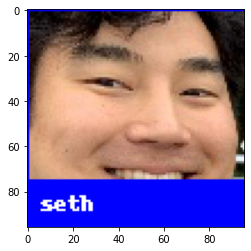

Looking for faces in seth10.jpg
- Found seth at (0, 0)


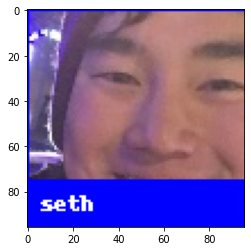

Looking for faces in seth11.jpg
- Found seth at (0, 0)


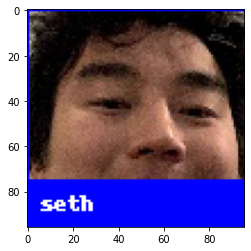

Looking for faces in seth12.jpg
- Found seth at (0, 0)


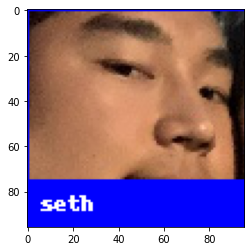

Looking for faces in seth13.jpg
- Found seth at (0, 0)


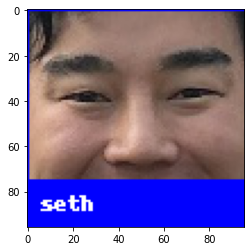

Looking for faces in seth14.jpg
- Found seth at (0, 0)


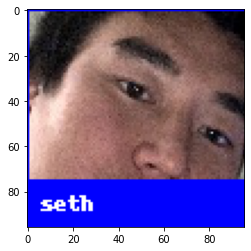

Looking for faces in seth15.jpg
- Found seth at (0, 0)


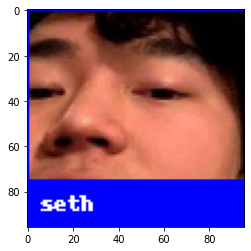

Looking for faces in seth16.jpg
- Found seth at (0, 0)


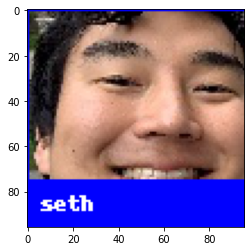

Looking for faces in seth17.jpg
- Found seth at (0, 0)


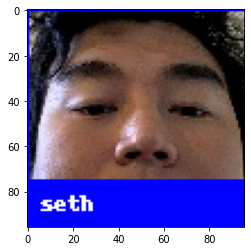

Looking for faces in seth18.jpg
- Found seth at (0, 0)


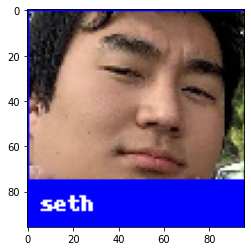

Looking for faces in seth19.jpg
- Found seth at (0, 0)


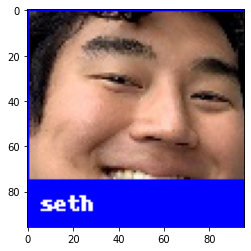

Looking for faces in seth2.jpg
- Found seth at (0, 0)


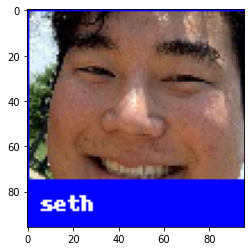

Looking for faces in seth20.jpg
- Found seth at (0, 0)


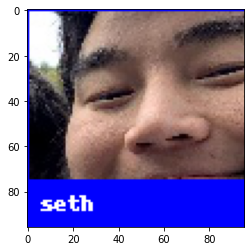

Looking for faces in seth21.jpg
- Found seth at (0, 0)


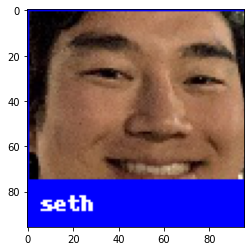

Looking for faces in seth22.jpg
- Found seth at (0, 0)


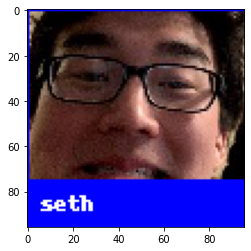

Looking for faces in seth23.jpg
- Found seth at (0, 0)


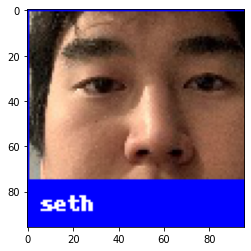

Looking for faces in seth24.jpg
- Found seth at (0, 0)


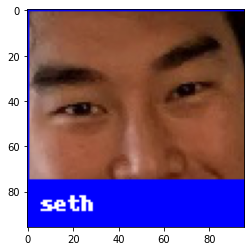

Looking for faces in seth25.jpg
- Found seth at (0, 0)


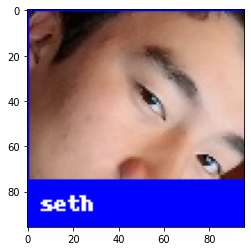

Looking for faces in seth26.jpg
- Found seth at (0, 0)


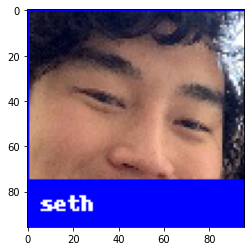

Looking for faces in seth27.jpg
- Found seth at (0, 0)


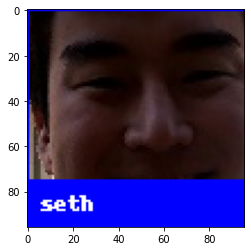

Looking for faces in seth28.jpg
- Found seth at (0, 0)


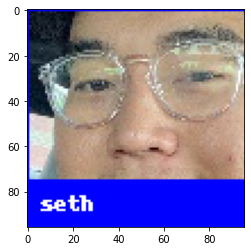

Looking for faces in seth29.jpg
- Found seth at (0, 0)


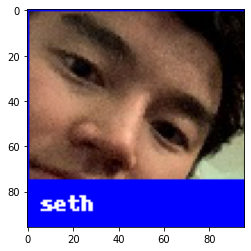

Looking for faces in seth3.jpg
- Found seth at (0, 0)


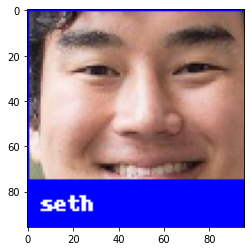

Looking for faces in seth30.jpg
- Found seth at (0, 0)


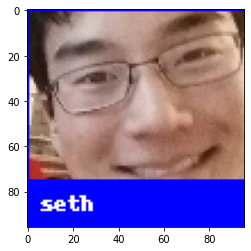

Looking for faces in seth31.jpg
- Found seth at (0, 0)


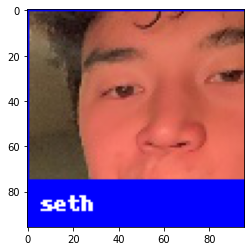

Looking for faces in seth32.jpg
- Found seth at (0, 0)


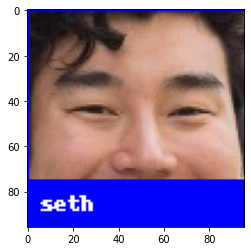

Looking for faces in seth33.jpg
- Found seth at (0, 0)


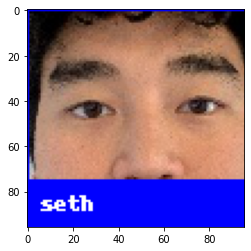

Looking for faces in seth34.jpg
- Found unknown at (0, 0)


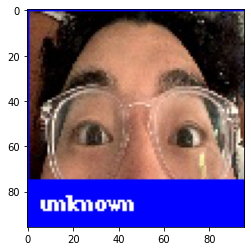

Looking for faces in seth35.jpg
- Found seth at (0, 0)


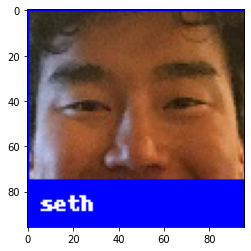

Looking for faces in seth36.jpg
- Found seth at (0, 0)


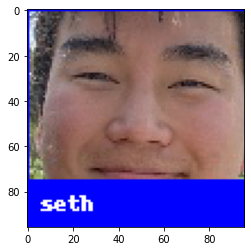

Looking for faces in seth37.jpg
- Found seth at (0, 0)


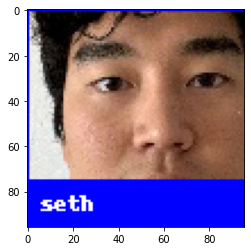

Looking for faces in seth38.jpg
- Found seth at (0, 0)


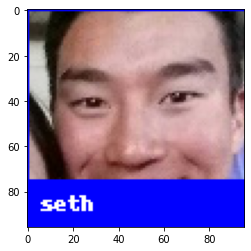

Looking for faces in seth39.jpg
- Found seth at (0, 0)


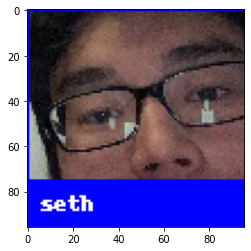

Looking for faces in seth4.jpg
- Found seth at (0, 0)


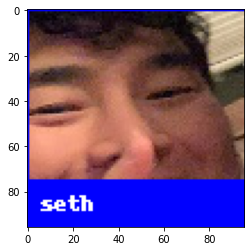

Looking for faces in seth40.jpg
- Found seth at (0, 0)


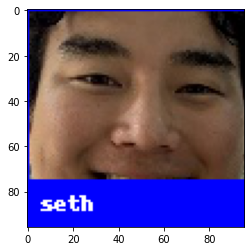

Looking for faces in seth41.jpg
- Found seth at (0, 0)


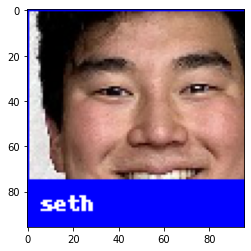

Looking for faces in seth5.jpg
- Found seth at (0, 0)


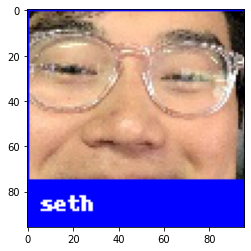

Looking for faces in seth6.jpg
- Found seth at (0, 0)


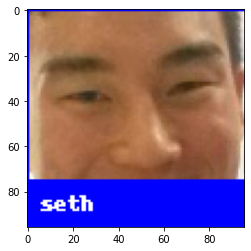

Looking for faces in seth7.jpg
- Found seth at (0, 0)


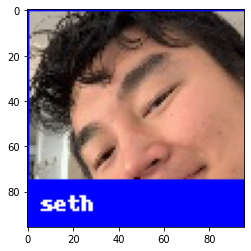

Looking for faces in seth8.jpg
- Found seth at (0, 0)


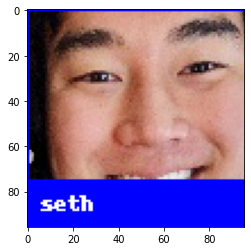

Looking for faces in seth9.jpg
- Found seth at (0, 0)


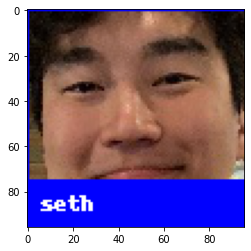

In [39]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import numpy as np 

names = []
# Iterate over test images
for image_file in os.listdir("data/test/seth"):
    if image_file[len(image_file)-1] != 'g':
        continue
    full_file_path = os.path.join("data/test/seth", image_file)

    print("Looking for faces in {}".format(image_file))

    # Find all people in the image using a trained classifier model
    # Note: You can pass in either a classifier file name or a classifier model instance
    predictions = face_recog.predict(full_file_path, cropped_face = True, model_path="models/trained_knn_model.clf")

    # Print results on the console
    for name, (top, right, bottom, left) in predictions:
        print("- Found {} at ({}, {})".format(name, left, top))

    # Display results overlaid on an image
    # face_recog.show_prediction_labels_on_image(os.path.join("data/test/claire", image_file), predictions)
    img_path = os.path.join("data/test/seth", image_file)
    
    pil_image = Image.open(img_path).convert("RGB")
    draw = ImageDraw.Draw(pil_image)
    for name, (top, right, bottom, left) in predictions:
        names.append(name)
        # Draw a box around the face using the Pillow module
        draw.rectangle(((left, top), (right, bottom)), outline=(0, 0, 255))

        # There's a bug in Pillow where it blows up with non-UTF-8 text
        # when using the default bitmap font
        name = name.encode("UTF-8")

        # Draw a label with a name below the face
        text_width, text_height = draw.textsize(name)
        draw.rectangle(((left, bottom - text_height - 10), (right, bottom)), fill=(0, 0, 255), outline=(0, 0, 255))
        draw.text((left + 6, bottom - text_height - 5), name, fill=(255, 255, 255, 255))
        
    del draw

    # Display the resulting image
    plt.imshow(np.array(pil_image))
    plt.show()
    


In [17]:
print(f"Prediction accurary on the Test set: {round(np.mean(np.array(names) == 'seth'), 3)}")

Prediction accurary on the Test set: 0.976


In [25]:
def get_predictions(path):
    names = []
    # STEP 2: Using the trained classifier, make predictions for unknown images
    for image_file in os.listdir(path):
        if image_file[len(image_file)-1] != 'g':
            continue
        full_file_path = os.path.join(path, image_file)

        # Find all people in the image using a trained classifier model
        # Note: You can pass in either a classifier file name or a classifier model instance
        predictions = face_recog.predict(full_file_path, cropped_face = True, model_path="models/trained_knn_model.clf")
        
        for name, _ in predictions:
            names.append(name)

    return np.array(names)

In [30]:
print(f"Prediction accurary on the Test set - Claire: {round(np.mean(get_predictions('data/test/claire') == 'claire'), 3)}")
print(f"Prediction accurary on the Test set - Jordyn: {round(np.mean(get_predictions('data/test/jordyn') == 'jordyn'), 3)}")


Prediction accurary on the Test set - Claire: 1.0
Prediction accurary on the Test set - Jordyn: 0.92


## End of training pipeline

- TODO, make this into an executable script and instrument it. 

# Inference Sandbox

Looking for faces in seth1.jpg
1891 1891 3042 741


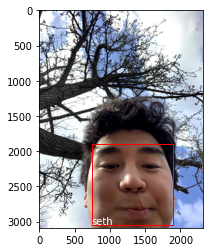

Looking for faces in seth10.jpg
1343 2328 1897 1774


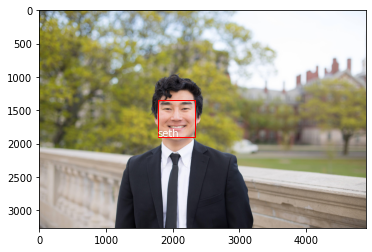

Looking for faces in seth11.jpg
1963 2116 3088 736


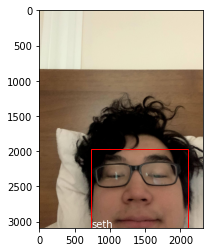

In [54]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import numpy as np 
import matplotlib


for image_file in os.listdir("data/images-custom/seth")[0:5]:
    if image_file[len(image_file)-1] != 'g':
        continue
    full_file_path = os.path.join("data/images-custom/seth", image_file)

    print("Looking for faces in {}".format(image_file))

    # Run predictions
    predictions = face_recog.predict(full_file_path, cropped_face = False, model_path="models/trained_knn_model.clf")

    # Display results overlaid on an image
    img_path = os.path.join("data/images-custom/seth", image_file)
    
    pil_image = Image.open(img_path).convert("RGB")
    figure, ax = plt.subplots(1)
    ax.imshow(np.array(pil_image))
    # draw = ImageDraw.Draw(pil_image)
    for name, (top, right, bottom, left) in predictions:
        # Draw a box around the face using matplotlib
        rect = matplotlib.patches.Rectangle((left,bottom),right - left,top - bottom, edgecolor='r', facecolor="none")
        ax.add_patch(rect)
        # There's a bug in Pillow where it blows up with non-UTF-8 text
        # when using the default bitmap font
        ax.text(left, bottom - 5, name,color='white', fontsize=10)
        
    plt.show()


